# Interprétabilité du modèle :
## Récupération et entraînement du modèle . (Ajout des noms des features)

In [28]:
import sys
import os
sys.path.append("..")
from churn.infrastructure.bank_customers import BankCustomersData
from churn.domain.churn_model import ChurnModelSelection, ChurnModelFinal
from churn.config.config import retrieve_optimal_parameters, transform_to_object
from interpret import show
from sklearn.pipeline import Pipeline
from interpret.glassbox import DecisionListClassifier
from churn.domain.bank_customers_dataset import FeaturesDataset
from sklearn.preprocessing import StandardScaler
from churn.domain.domain_utils import get_train_test_split

In [102]:
#Récupération des noms de features. (Obligé de passer par un objet fitté)
original_model = ChurnModelSelection.load()
original_feature_dataset = original_model.pipe[0]
feature_names = original_feature_dataset.get_feature_names_out()
latest_best_params = transform_to_object("../churn/config/latest_model.yml","model_parameters")[0]
model_name = latest_best_params["pipe__classifier"][0]
#Ajout des noms des features 
latest_best_params["pipe__classifier__feature_names"] = feature_names
#Removing model name for the set_params command
del latest_best_params["pipe__classifier"]
#Réentraînement d'un modèle avec les paramètres optimaux
model = ChurnModelSelection(pipe=Pipeline([('features',FeaturesDataset()),
                                            ('classifier', ExplainableBoostingClassifier())]))
model.set_params(**latest_best_params)
X_train, X_test, y_train, y_test = get_train_test_split()
model.fit(X_train,y_train)


ChurnModelSelection(pipe=Pipeline(steps=[('features',
                                          Pipeline(steps=[('imputer',
                                                           FeaturesImputer(balance_imputation='mean', balance_zero=True)),
                                                          ('col_transform',
                                                           ColumnTransformer(remainder='passthrough',
                                                                             transformers=[('onehotencoder',
                                                                                            OneHotEncoder(handle_unknown='ignore'),
                                                                                            ['PAYS']),
                                                                                           ('drop',
                                                                                            'drop',
                                                                                            ['NOM',
                                                                                             'DATE_ENTREE'])]))])),
                                         ('classifier',
                                          Explainable...
                                                                        feature_types=['categorical',
                                                                                       'categorical',
                                                                                       'categorical',
                                                                                       'continuous',
                                                                                       'continuous',
                                                                                       'categorical',
                                                                                       'continuous',
                                                                                       'continuous',
                                                                                       'categorical',
                                                                                       'continuous',
                                                                                       'categorical',
                                                                                       'categorical',
                                                                                       'interaction',
                                                                                       'interaction',
                                                                                       'interaction',
                                                                                       'interaction',
                                                                                       'interaction',
                                                                                       'interaction',
                                                                                       'interaction',
                                                                                       'interaction',
                                                                                       'interaction',
                                                                                       'interaction'],
                                                                        learning_rate=0.09501688225703216,
                                                                        outer_bags=10))]))

## Explicabilité du modèle
### Explainable Boosting Classifier
Les images ci-dessous proviennent de la méthode explain_global de l'objet ExplainableBoostingClassifier : 
#### Aperçu global des features les plus importantes. :
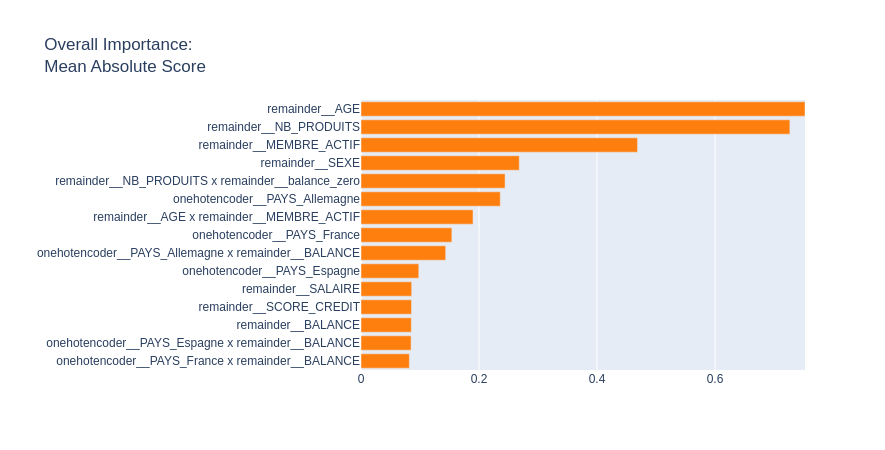
Nous remarquons que les features les plus importantes sont l'âge, le nombre de produit ainsi que si le membre est actif. 
Ce qui fait sens car en effet, ce qui fait l'attrait d'un client à un service de banque se mesure par l'intéret qu'il y trouve (nombre de produit, et membre actif). 
#### Visualisation de l'impact de l'age sur le score :
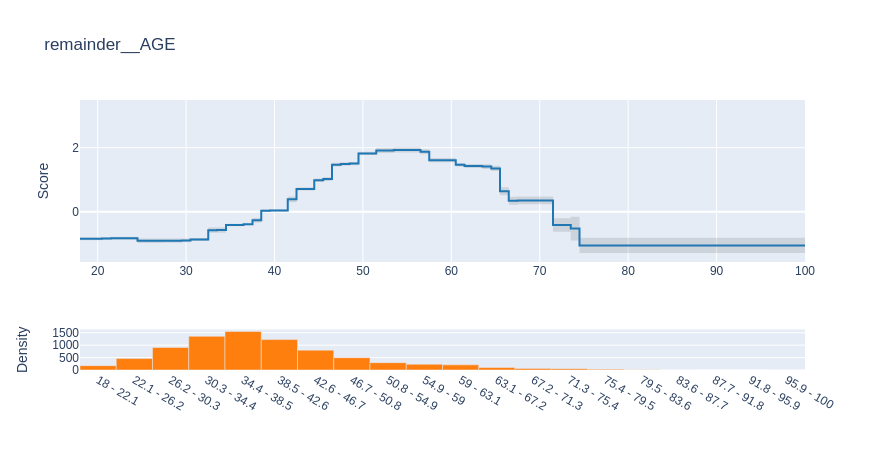
Cette variable est très importante pour notre modèle, car nous remarquons qu'au dessus de 42, 43 ans le lien entre l'âge et le taux de churn se fait de plus en plus fort en peu de temps. 
Pour se trouver au maximum entre 48 et 56 ans : Analyse : A vérifier, mais peut être que nous sommes à un âge charnier où les carrières font de grands bonds et donc les choix de produits financiers et de banque aussi. (Crise de la cinquantaine, voyages, changement de travail, etc...)
#### Visualisation du couple Age / Membre actif : 
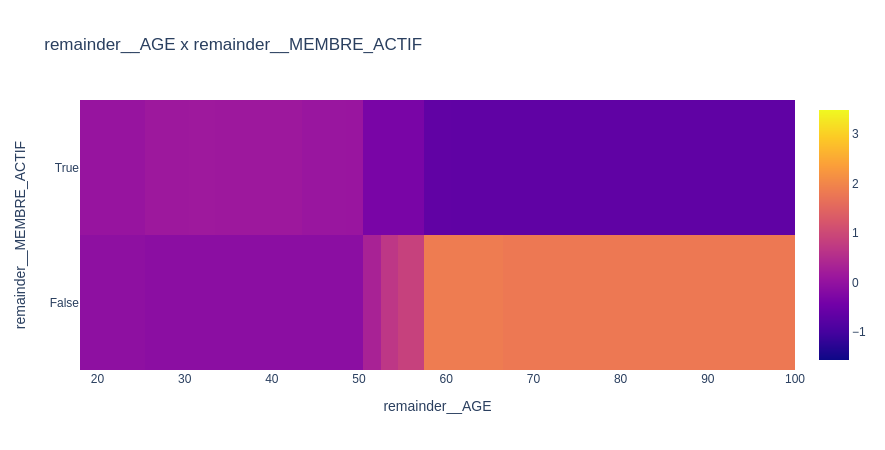
L'image ci dessus est facile à comprendre, un membre actif de plus de 60 ans aura systématiquement tendance à ne pas "churner", alors qu'un membre inactif de plus de 60 ans aura systématiquement tendance à "churner"

In [108]:
ebc = model.get_params(deep=True)["pipe__classifier"]
ebc_global = ebc.explain_global()
show(ebc_global)

<!-- http://127.0.0.1:7001/140580412623696/ -->

###  Skope Rules
La méthode skope rules permet d'extraire des règles de décisions simples et interprétables, pour comprendre le "raisonnement" du modèle. Ces règles sont des simples  𝐼𝐹   (...)   𝑇𝐻𝐸𝑁   𝑃𝑟𝑒𝑑𝑖𝑐𝑡𝑖𝑜𝑛  extraites à partir d'un ensemble d'arbres de décision.  
Par exemple :
    - Un membre inactif
    - Agé de plus de 48 ans 
Sera prédit avec une précision de 0.899, et aura un recall de 0.44.
D'un point de vue métier cela recoupe avec les informations que nous avons déduit précédemment, nous sommes cohérents. 

In [99]:
y_pred_test = model.predict(X_test)
#Nous créons un modèle contenant un classifier de type DecisionListClassifier
model_skope = ChurnModelSelection(pipe=Pipeline([('features',FeaturesDataset()),
                                            ('classifier', DecisionListClassifier(feature_names=feature_names))]))
model_skope.fit(X_test, y_pred_test)
dl_global = model_skope.get_params(deep=True)["pipe__classifier"].explain_global()
show(dl_global)

<!-- http://127.0.0.1:7001/140580491043600/ -->